#### Lineage Examples and Walkthrough
This Notebook demonstrates various approaches to adding assets and lineage - it covers the creation of basic Atlas contructs through a series of examples and finishes with a small end-to-end example.

#### Configuration

In [5]:

import yaml, requests, json

# Open the config file to read the client details
with open("../config/config.yaml", "r") as yamlfile:
    config = yaml.load(yamlfile, Loader=yaml.FullLoader)

client_id = config[0]['client_id']
client_secret = config[0]['client_secret']
tenant_id = config[0]['tenant_id']
purview_account_name = config[0]['purview_account_name']
scope = f"{config[0]['resource']}/.default"
purview_endpoint = f"https://{purview_account_name}.purview.azure.com"
authority = f"https://login.microsoftonline.com/{tenant_id}"

access_token = ""

#### Functions

In [6]:
# Function to construct header for HTTP requests
# Parameters:  None
# Returns: Dictionary with header information
##
def getHeaders():
    headers = {
        'Authorization': f'Bearer {access_token}',
        'Content-Type': 'application/json'
    }
    return headers;

In [7]:
# Function to search a given collection and retrieve all assets.  Returns a searchresult object ordered by guid
# Parameters:  
#   limit:              Batch size to return (50-1000)
#   collection:         Id of the collection we are searching
# Returns:  Ordered dict object with Search Results sorted by guid (https://learn.microsoft.com/en-us/rest/api/purview/catalogdataplane/discovery/query?tabs=HTTP#searchresult)
##
def queryForNextBatch(limit, collection):

    search_uri = f"{purview_endpoint}/catalog/api/search/query?api-version=2022-03-01-preview"
    payload = json.dumps({
        "keywords": None,
        "limit": limit,
        "filter": {        
            "collectionId": collection
        },
        "offset": 0,
        "limit": limit
    })

    response = json.loads(requests.request("POST", search_uri, data=payload, headers=getHeaders()).content)
    return response

#### 1. OAuth Login
Perform Authentication using the Microsoft Authentication Library and get a bearer token for subsequent API calls

In [8]:
from msal import ConfidentialClientApplication

app = ConfidentialClientApplication(client_id, authority=authority, client_credential=client_secret)
result = app.acquire_token_for_client(scopes=scope)

access_token = result['access_token']

#### 2. Collection creation
Create a Purview collection for the metadata assets that will be created as part of this walkthrough

In [9]:
# Initial setup:  Create the collection and keep a reference to it
collection_id = "api-collection"
collection_friendly_name = "API Collection"

# Create a collection for the assets
url_collection = f"{purview_endpoint}/account/collections/{collection_id}?api-version=2019-11-01-preview"

payload = json.dumps({
    "friendlyName": collection_friendly_name,
    "parentCollection": {
        "referenceName": purview_account_name
    }
})

response = json.loads(requests.request("PUT", url_collection, headers=getHeaders(), data=payload).content)
print(response)

{'name': 'api-collection', 'friendlyName': 'API Collection', 'parentCollection': {'type': 'CollectionReference', 'referenceName': 'pvdemoarfj5-pv'}, 'systemData': {'createdBy': '7eaa48aa-bf97-45e3-bb71-2937af479741', 'createdByType': 'Application', 'createdAt': '2023-03-22T10:04:21.6660101Z', 'lastModifiedBy': '7eaa48aa-bf97-45e3-bb71-2937af479741', 'lastModifiedByType': 'Application', 'lastModifiedAt': '2023-03-22T10:04:21.6660102Z'}, 'collectionProvisioningState': 'Succeeded'}


#### 3. About Atlas Types
Types in Apache Atlas are definitions of how particular types of metadata objects are stored and accessed.  A type represents one or a collection of attributes that define the properties for the metadata object.  Types are similar to a 'Class' definition in Object Oriented programming or a 'Table Schema' in a relational database.  Instances of Types are called 'Entities'.

Each Type has a metatype.  Atlas has the following metatypes:

-Primitives metatypes: boolean, byte, short, int, long, float, double, biginteger, bigdecimal, string, date
-Enum metatypes
-Collection metatypes: array, map
-Composite metatypes: Entity, Struct, Classification, Relationship

### 3.1. System specific Types
There are a few different pre-defined types that offer a starting point for any custom types.  

**Referenceable:** Represents all entities that can be searched for using a unique attribute called qualifiedName
</br>**Asset:** Extends Referenceable and adds attributes like name, description and owner.

*The purpose of Referenceable and Asset is to provide modellers with a way to enforce consistency when defining and querying entities of their own types.  Having these fixed set of attributes allows applications and interfaces to make convention-based assumptions about what atributes they can expect by default.  In Purview, for example, ALL entities have a guid, an FQDN and a name by default, irrespecgive of types.*

**Infrastructure:** Extends Asset and can be used as a common super type for infrastrctural metadata like clusters, hosts, etc.  Note, this type is not currently used within Purview, but it can be created and used just like any other type.

**DataSet:** Extends Asset and conceptually can be used to represent a type that stores data, for example a file or a table.  Types that extend DataSet typically have a schema and can also participate in data transformation which can be captured via Lineage graphs.

**Process:** Extends Asset and can be used to represent any data transformation operation.  A Process Type typically has two specific attributes, inputs and outputs.  Both inputs and outputs are arrays of DataSet entities and are the basis for representing lineage.

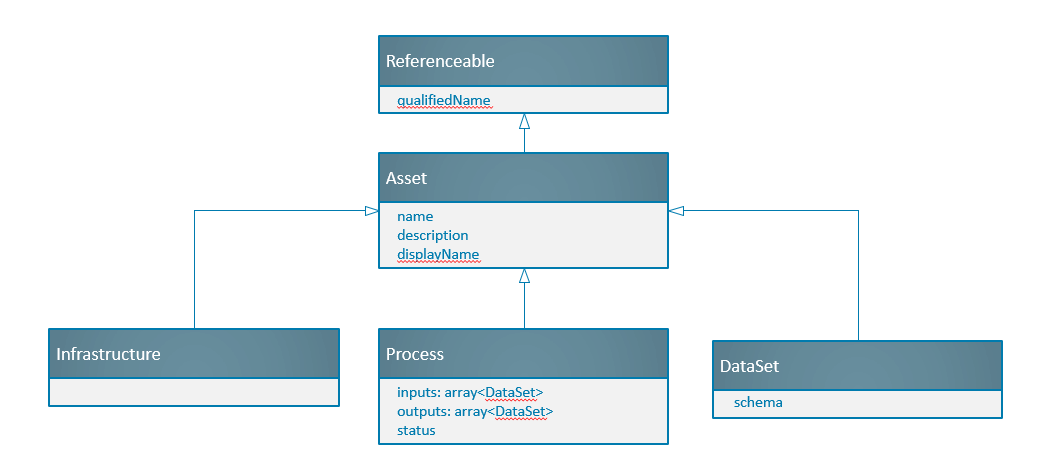

Every type can be queried via the API which is helpful in determining it's structure.  Let's take a look at some examples in the next cell.

In [10]:
# Query the Atlas Type system to return details about different Types.  Try examining different Types such as Referenceable, Asset, DataSet, and Process 
type_name = "DataSet"
url_types = f"{purview_endpoint}/catalog/api/atlas/v2/types/entitydef/name/{type_name}"

response = json.loads(requests.request("GET", url_types, headers=getHeaders()).content)
print(json.dumps(response, indent=2))

{
  "category": "ENTITY",
  "guid": "46e7cd3b-9eed-ee40-0083-3bdd0c3e9bb3",
  "createdBy": "admin",
  "updatedBy": "admin",
  "createTime": 1678529764405,
  "updateTime": 1678529764405,
  "version": 3,
  "name": "DataSet",
  "description": "DataSet",
  "typeVersion": "1.2",
  "serviceType": "atlas_core",
  "lastModifiedTS": "3",
  "attributeDefs": [],
  "superTypes": [
    "Asset"
  ],
  "subTypes": [
    "azure_mariadb_view_column",
    "azure_sql_dw_column",
    "sap_hana_view",
    "aws_rds_mysql_table",
    "oracle_view",
    "ozone_volume",
    "spark_column",
    "spark_table",
    "looker_join",
    "hive_view_column",
    "hive_column",
    "xml_element",
    "azure_sql_dw_view",
    "sap_bw_hybrid_provider",
    "azure_synapse_lake_database_view_column",
    "azure_blob_path",
    "sap_bw_aggregate_cube",
    "oracle_package",
    "ml_project",
    "sap_bw_query_view",
    "powerbi_dataflow",
    "sap_s4hana_view",
    "sap_bw_key_figure",
    "schema",
    "db2_table_column",

#### 4. Creating Lineage using Relationships
In order to create lineage, we need to create relationships.  In the Type examples above, Process Types can be used with inputs and outputs to create lineage.  Let's create a simple example of a Process (Customer Process) with an input DataSet (Person) and an output DataSet (Customer).

*In this example, we create all the entities in one call and there is no need to explicitly create a relationship.  By defining the inputs and output guids as part of the process as well as the types , Purview will infer the relationships based on the type definition and create them automatically.  Note also the use of guid 'tokens' instead of full guids.*

In [11]:
# Use the collection bulk create API to upload a batch of entities
url_bulk = f"{purview_endpoint}/catalog/api/collections/{collection_id}/entity/bulk?api-version=2022-03-01-preview"

payload = json.dumps({
  "referredEntities": {},
  "entities": [
    {
      "typeName": "DataSet",
      "guid": "-1",
      "attributes": {
        "name": "Person", 
        "qualifiedName": "dataset://person"
      }
    },
    {
      "typeName": "DataSet",
      "guid": "-2",
      "attributes": {
        "name": "Customer", 
        "qualifiedName": "dataset://customer"
      }
    },
    {
        "typeName": "Process",
        "guid": "-1000",
        "attributes": {
            "name": "Customer Process",
            "qualifiedName": "process://customer",
            "inputs": [{ "guid": "-1", "typeName": "DataSet"}],
            "outputs": [{ "guid": "-2", "typeName": "DataSet"}]
        }
    }
  ]  
})

response = json.loads(requests.request("POST", url_bulk, headers=getHeaders(), data=payload).content)

# Get the generated guids list from the returned dictionary (use these to reference the 'real' guids later)
guid_assignments = response['guidAssignments']

#### 4.1. Examining what has been created
Using the Get Entity API call we can examine some of the entities that have been created.  In the example below, we query for the Process that we just created and in the returned object there's a property called 'relationshipAttributes' which contains two new Types 'dataset_process_inputs' and 'dataset_process_outputs' each with it's own guid called 'relationshipGuid'.  These are the relationships that were automatically created as part of the call above.  In the next few cells we'll create one of these relationships implicitly.

In the Purview UI, the lineage should also be populated:

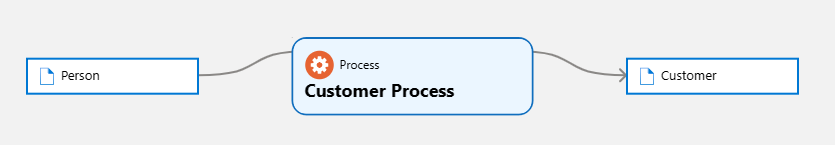

In [12]:
# Use the Get Entity by GUID API call using the guid_assignments list with the key we used in the previous cell (our own reference to the Process)
url_entity = f"{purview_endpoint}/catalog/api/atlas/v2/entity/guid/{guid_assignments['-1000']}"
response = json.loads(requests.request("GET", url_entity, headers=getHeaders()).content)

print( json.dumps(response['entity']['relationshipAttributes'], indent=2))

{
  "outputs": [
    {
      "guid": "5aa38525-a7ea-4f9d-91c2-0e0b390dff26",
      "typeName": "DataSet",
      "entityStatus": "ACTIVE",
      "displayText": "Customer",
      "relationshipType": "process_dataset_outputs",
      "relationshipGuid": "1d78df76-37b7-4430-a5e2-31691bbef6ad",
      "relationshipStatus": "ACTIVE",
      "relationshipAttributes": {
        "typeName": "process_dataset_outputs"
      }
    }
  ],
  "inputs": [
    {
      "guid": "fd3ade79-4790-43fe-a66b-c2d3533877b5",
      "typeName": "DataSet",
      "entityStatus": "ACTIVE",
      "displayText": "Person",
      "relationshipType": "dataset_process_inputs",
      "relationshipGuid": "413d7c0c-e0a9-485e-aed3-dc27bec25da3",
      "relationshipStatus": "ACTIVE",
      "relationshipAttributes": {
        "typeName": "dataset_process_inputs"
      }
    }
  ],
  "meanings": []
}


#### 5. Creating relationships explicitly
In the above example, we created a couple of entities and a process to tie them together.  The input and output relationships for the Process were automatically created when we provided references to the Datasets.  But what do we do if the entities already exist?  Consider entities created by an automated scan that we wish to augment with additional lineage.  To do this we can explicitly define a relationship.  

Let's create another entity to demonstrate this.  We'll create a new entity called 'Address' but we won't define any relationship just yet.  In a future step, we'll explicitly create a Relationship to describe this entity as an input into our Process.

In [13]:
# Use the collection bulk create or update API request to upload a single entity
url_bulk = f"{purview_endpoint}/catalog/api/collections/{collection_id}/entity?api-version=2022-03-01-preview"

payload = json.dumps({
  "referredEntities": {},
  "entity":
  {
    "typeName": "DataSet",
    "guid": "-3",
    "attributes": {
      "name": "Address", 
      "qualifiedName": "dataset://address"
    }
  } 
})

response = json.loads(requests.request("POST", url_bulk, headers=getHeaders(), data=payload).content)

# Get the generated guids list from the returned dictionary and add them to our dictionary (use these to reference the 'real' guids later)
guid_assignments.update(response['guidAssignments'])

#### 5.1. Validate the DataSet has no relationship
Now that we've created the entity, let's examine the relationshipAttributes property.  As you can see there are a number of relationship properties but the two of interest are the "inputToProcesses" and the "outputFromProcesses" which are both empty.  Note also, in the Purview UI, the entity is created but has no relationship.

In [14]:
# Use the Get Entity by GUID API call using the guid_assignments list with the key we used in the previous cell (our own reference to the Process)
url_entity = f"{purview_endpoint}/catalog/api/atlas/v2/entity/guid/{guid_assignments['-3']}"
response = json.loads(requests.request("GET", url_entity, headers=getHeaders()).content)

print( json.dumps(response['entity']['relationshipAttributes'], indent=2))

{
  "schema": [],
  "inputToProcesses": [],
  "sources": [],
  "sinks": [],
  "attachedSchema": [],
  "meanings": [],
  "outputFromProcesses": []
}


#### 5.2. Understanding the Relationship Type
With the entity created, we can now create the relationship to our process.  Relationships have semantic meaning and can be modelled with additional attributes, just like any other Type.  Relationships have their own Types which we have already seen in a previous example.  When we created our Process, there were two relationships created; 'dataset_process_inputs' and 'dataset_process_outputs'.  In our example we want to represent the 'Address' entity as an input to our 'Customer Process' so we'll use the 'dataset_process_inputs' Type.  Let's examine this Type a little closer:

In [15]:
# Query the Atlas Type system to return details about the 'dataset_process_inputs' relationship. 
type_name = "dataset_process_inputs"
url_types = f"{purview_endpoint}/catalog/api/atlas/v2/types/relationshipdef/name/{type_name}"

response = json.loads(requests.request("GET", url_types, headers=getHeaders()).content)
print(json.dumps(response, indent=2))

{
  "category": "RELATIONSHIP",
  "guid": "27a78655-4c6c-2381-1874-0abb6ee90dd9",
  "createdBy": "admin",
  "updatedBy": "admin",
  "createTime": 1678529764406,
  "updateTime": 1678529764406,
  "version": 2,
  "name": "dataset_process_inputs",
  "description": "dataset_process_inputs",
  "typeVersion": "1.1",
  "serviceType": "atlas_core",
  "lastModifiedTS": "2",
  "attributeDefs": [],
  "relationshipCategory": "AGGREGATION",
  "propagateTags": "TWO_TO_ONE",
  "endDef1": {
    "type": "Process",
    "name": "inputs",
    "isContainer": true,
    "cardinality": "SET",
    "isLegacyAttribute": true
  },
  "endDef2": {
    "type": "DataSet",
    "name": "inputToProcesses",
    "isContainer": false,
    "cardinality": "SET",
    "isLegacyAttribute": false
  }
}


#### 5.3. Creating the Relationship
In the above output there are a couple of key properties we need to define:

-endDef1: represents the Process side of the relationship with a SET cardinality (Can have multiple DataSet inputs) 
-endDef2: represents the DataSet side of the relationship with a SET cardinality (Can be the source for muliple Processes)

Let's define the relationship using this Type definition.  We can use he guid_assignments dictionary we created to find the Process and DataSet guids using our own keys:

In [16]:
# Use the relationship create API request to upload a relationship entity
url_relationship = f"{purview_endpoint}/catalog/api/atlas/v2/relationship?api-version=2022-03-01-preview"

payload = json.dumps({
    "typeName": "dataset_process_inputs",
    "end1": {
        "typeName": "Process",
        "guid": guid_assignments['-1000']
    },
    "end2": {
       "typeName": "DataSet",
        "guid": guid_assignments['-3']
    }
  })

response = json.loads(requests.request("POST", url_relationship, headers=getHeaders(), data=payload).content)
rel_guid = response['guid']

#### 6.4. Validate the relationship
Now that we've created the relationship we can validate by calling the Get Relationship API request.  In Purview the lineage graph should show the following:

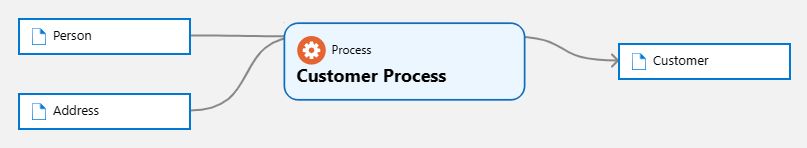

In [17]:
# Query the Get Relationship API using the relationship guid we captured earlier. 
url_relationship = f"{purview_endpoint}/catalog/api/atlas/v2/relationship/guid/{rel_guid}"

response = json.loads(requests.request("GET", url_relationship, headers=getHeaders()).content)
print(json.dumps(response, indent=2))

{
  "relationship": {
    "typeName": "dataset_process_inputs",
    "lastModifiedTS": "1",
    "guid": "28fae576-e2ad-4cac-a031-541a45f8381b",
    "provenanceType": 0,
    "end1": {
      "guid": "2db81ad1-7769-49ff-be12-92bee98fe321",
      "typeName": "Process",
      "uniqueAttributes": {
        "qualifiedName": "process://customer"
      }
    },
    "end2": {
      "guid": "262f6f84-1b4c-40ce-92a0-7fa7be9ba2fb",
      "typeName": "DataSet",
      "uniqueAttributes": {
        "qualifiedName": "dataset://address"
      }
    },
    "label": "__Process.inputs",
    "status": "ACTIVE",
    "createdBy": "7eaa48aa-bf97-45e3-bb71-2937af479741",
    "updatedBy": "7eaa48aa-bf97-45e3-bb71-2937af479741",
    "createTime": 1679479543751,
    "updateTime": 1679479543751,
    "version": 0,
    "propagatedClassifications": []
  }
}


#### 6. Column-level Lineage
Column-level lineage allows for mapping between individual columns in a dataset to understand how they may be transformed through a Process.  In Purview this is achieved by using a custom attribute called 'columnMapping' that's attached to the 'Process' entity.  If we examine the Process Type Definition (as we did in step 3.1) we can see that there is no attribute called 'columnMapping' in a 'Process' entity.  That's because this attribute is not part of the standard Atlas Types, but Purview does use this column in other sub-typed Processes.  In order to use this attribute we either need to use one of the many Process Types that Purview ships with (such as a Data Factroy Copy Operation) or we can create our own. 

#### 6.1. Creating a Custom Process Type
Let's create a simple Custom Type definition to capture some column level lineage - you can create your own Types to represent any kind of data or process.  As discribed at the start of this notebook, Types can extend other types to establish an inheritance model.  Let's extend the base  'Process' Type using the'superType' property: 

In [18]:
# Create custom Process definition (extending the existing Proess Type) with columnMapping attribute
url_types = f"{purview_endpoint}/catalog/api/atlas/v2/types/typedefs"

payload = json.dumps({
  "enumDefs": [],
  "structDefs": [],
  "classificationDefs": [],
  "entityDefs": [
    {
        "name": "custom_transform_process",
        "superTypes": ["Process"],
        "attributeDefs": [
        {
            "name": "columnMapping",
            "typeName": "string",
            "isOptional": True,
            "cardinality": "SINGLE",
            "valuesMinCount": 0,
            "valuesMaxCount": 1,
            "isUnique": False,
            "isIndexable": False,
            "includeInNotification": False
        }
      ]
    }
  ],
  "relationshipDefs": []
})

requests.request("POST", url_types, headers=getHeaders(), data=payload)

<Response [200]>

#### 6.2. Delete the existing Process
Before using the new process, let's clean up a little and delete the one we've just created as well as cleaning up our guid dictionary.  Validate that the Process is removed in Purview:

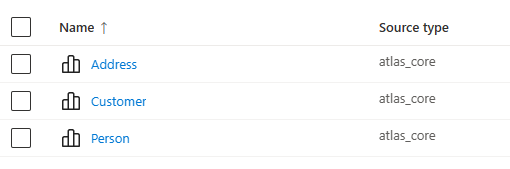

In [19]:
#Delete the existing Process first so it can be re-created with the new type definition (get the 'real' guid from the assignments dictionary created earlier)
url_delete = f"{purview_endpoint}/catalog/api/atlas/v2/entity/guid/{guid_assignments.get('-1000')}"

requests.request("DELETE", url_delete, headers=getHeaders())
guid_assignments.pop('-1000')

'2db81ad1-7769-49ff-be12-92bee98fe321'

#### 6.3. Creating an instance of our new Type
Now that we've created our new Process Type, we can create entities from it in the same way we did earlier.  This time, though, we need to define the 'columnMapping' attribute which is an embedded json string that has the following structure:

`[
    {
        "DatasetMapping" : {"Source": "<qualifiedName>", "Sink": "<qualifiedName>"},
        "ColumnMapping" : [ {"Source": "<columnName>", "Sink": "<columnName>"}, {"Source": "<columnName>", "Sink": "<columnName>"} ]
    }
]`

The property defines an array of dataset sources and sinks (the inputs and outputs), followed by a column mapping that contains an array of source/sink column pairs.  Add as many dataset mappings as needed.  

Let's create a new entity from our Type definition using the 'Person' and 'Address' entities as inputs and the 'Customer' entity as the output.  Note, Because this a json string embedded within a json string, we have to escape all our quotes within the call which can make it a little difficult to read:

In [20]:
url_create = f"{purview_endpoint}/catalog/api/collections/{collection_id}/entity?api-version=2022-03-01-preview"

payload = json.dumps({
  "referredEntities": {},
  "entity":{
        "typeName": "custom_transform_process",
        "guid": "-1000",
        "attributes": {
            "name": "Custom Person Process with Column Mapping",
            "qualifiedName": "//process/person",
            "inputs": [{ "guid": guid_assignments.get("-1"), "typeName": "DataSet"}, { "guid": guid_assignments.get("-3"), "typeName": "DataSet"}],
            "outputs": [{ "guid": guid_assignments.get("-2"), "typeName": "DataSet"}],
            "columnMapping":  "[" \
                                "{\"DatasetMapping\": {\"Source\":\"dataset://person\", \"Sink\":\"dataset://customer\"}," \
                                    "\"ColumnMapping\": [{\"Source\":\"First Name\",\"Sink\":\"Person Name\"}, {\"Source\":\"Last Name\",\"Sink\":\"Person Name\"}, {\"Source\":\"Date of Birth\",\"Sink\":\"Date of Birth\"}, {\"Source\":\"Email\",\"Sink\":\"Email\"}, {\"Source\":\"Telephone\",\"Sink\":\"Telephone\"}] }," \
                                "{\"DatasetMapping\": {\"Source\":\"dataset://address\", \"Sink\":\"dataset://customer\"}," \
                                    "\"ColumnMapping\": [{\"Source\":\"Street Address\",\"Sink\":\"Full Address\"}, {\"Source\":\"Town/City\",\"Sink\":\"Full Address\"}, {\"Source\":\"Postcode\",\"Sink\":\"Full Address\"}, {\"Source\":\"Address Type\",\"Sink\":\"Address Type\"}] }" \
                              "]"
        }
    }
})

response = json.loads(requests.request("POST", url_create, headers=getHeaders(), data=payload).content)
# Get the generated guids list from the returned dictionary and add them to our dictionary
guid_assignments.update(response['guidAssignments'])

#### 7. Schemas and Columns
Once the above process entity is created you should now see the lineage and column menu display in the Purview Lineage view (this may require a refresh of the page).  

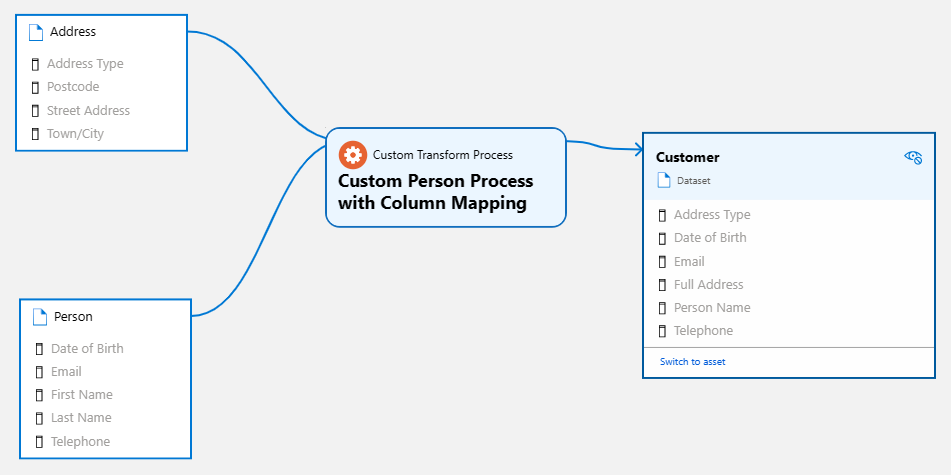

It should be noted that the column mappings are visible depite the fact that we created the datasets without any schemas or columns.  This is because the column mapping is a completely separate attribute on the process used to faciliate this UI and nothing else.  In Atlas, each column can be a seperate entity with relationships to schemas and datasets so it would be possible to create detailed lineage linking each source columns to each sink column, but this would make for a complex lineage graph.  This method places all relevant mappings in the Process itself, making for a simpler model and easier graph traversal (and presumably a more efficient UI experience).

It would stll be appropriate, however, to create schemas and columns so that we can appropriately tag and classify columns.  To do this we can leverage the  basic Types 'tabular_schema' and 'column':

In [21]:
# This bulk operation can be used to create several assets into a collection
url_bulk = f"{purview_endpoint}/catalog/api/collections/{collection_id}/entity/bulk?api-version=2022-03-01-preview"

payload = json.dumps({
  "referredEntities": {},
  "entities": [
    {
        "typeName": "tabular_schema",
        "guid": "-10",
        "attributes": {
            "name": "Person Schema",
            "qualifiedName": "dataset//person/schema",
            "associatedDataSets": [{"guid": guid_assignments.get("-1"), "typeName": "DataSet"}]
        }
    },
    {   
        "typeName": "column",
        "guid": "-101",
        "attributes": {
            "name": "First Name",
            "qualifiedName": "dataset//person//schema#first_name",
            "type": "string",
            "composeSchema": { "guid": "-10", "typeName": "tabular_schema"}
        }
    },
    {
        "typeName": "column",
        "guid": "-102",
        "attributes": {
            "name": "Last Name",
            "qualifiedName": "dataset//person/schema#last_name",
            "type": "string",
            "composeSchema": { "guid": "-10", "typeName": "tabular_schema"}
        }
    },
    {
        "typeName": "column",
        "guid": "-103",
        "attributes": {
            "name": "Date of Birth",
            "qualifiedName": "dataset//person/schema#date_of_birth",
            "type": "string",
            "composeSchema": { "guid": "-10", "typeName": "tabular_schema"}
        }
    },
    {
        "typeName": "column",
        "guid": "-104",
        "attributes": {
            "name": "Telephone",
            "qualifiedName": "dataset//person/schema#telephone",
            "type": "string",
            "composeSchema": { "guid": "-10", "typeName": "tabular_schema"}
        }
    },
    {
        "typeName": "column",
        "guid": "-105",
        "attributes": {
            "name": "Email",
            "qualifiedName": "dataset//person/schema#email",
            "type": "string",
            "composeSchema": { "guid": "-10", "typeName": "tabular_schema"}
        }
    },
    {
        "typeName": "tabular_schema",
        "guid": "-30",
        "attributes": {
            "name": "Address Schema",
            "qualifiedName": "dataset//address/schema",
            "associatedDataSets": [{"guid": guid_assignments.get("-3"), "typeName": "DataSet"}]
 
        }
    },
    {   
        "typeName": "column",
        "guid": "-301",
        "attributes": {
            "name": "Street Address",
            "qualifiedName": "dataset//address/schema#street_address",
            "type": "string",
            "composeSchema": { "guid": "-30", "typeName": "tabular_schema"}
        }
    },
    {
        "typeName": "column",
        "guid": "-302",
        "attributes": {
            "name": "Locality",
            "qualifiedName": "dataset//address/schema#locality",
            "type": "integer",
            "composeSchema": { "guid": "-30", "typeName": "tabular_schema"}
        }
    },
    {
        "typeName": "column",
        "guid": "-303",
        "attributes": {
            "name": "Town/City",
            "qualifiedName": "dataset//address/schema#town_city",
            "type": "string",
            "composeSchema": { "guid": "-30", "typeName": "tabular_schema"}
        }
    },
    {
        "typeName": "column",
        "guid": "-304",
        "attributes": {
            "name": "Postcode",
            "qualifiedName": "dataset//address/schema#postcode",
            "type": "string",
            "composeSchema": { "guid": "-30", "typeName": "tabular_schema"}
        }
    },
    {
        "typeName": "column",
        "guid": "-305",
        "attributes": {
            "name": "Person Id",
            "qualifiedName": "dataset//address/schema#person_id",
            "type": "string",
            "composeSchema": { "guid": "-30", "typeName": "tabular_schema"}
        }
    },
    {
        "typeName": "column",
        "guid": "-306",
        "attributes": {
            "name": "Address Type",
            "qualifiedName": "dataset//address/schema#address_type",
            "type": "string",
            "composeSchema": { "guid": "-30", "typeName": "tabular_schema"}
        }
    },
    {
        "typeName": "tabular_schema",
        "guid": "-20",
        "attributes": {
            "name": "Person Dimension Schema",
            "qualifiedName": "dataset//customer/schema",
            "associatedDataSets": [{"guid": guid_assignments.get("-2"), "typeName": "DataSet"}]
 
        }
    },
    {
        "typeName": "column",
        "guid": "-201",
        "attributes": {
            "name": "Person Name",
            "qualifiedName": "dataset//customer/schema#person_name",
            "type": "string",
            "composeSchema": { "guid": "-20", "typeName": "tabular_schema"}
        }
    },
    {
        "typeName": "column",
        "guid": "-202",
        "attributes": {
            "name": "Full Address",
            "qualifiedName": "dataset//customer/schema#full_address",
            "type": "string",
            "composeSchema": { "guid": "-20", "typeName": "tabular_schema"}
        }
    },
    {
        "typeName": "column",
        "guid": "-203",
        "attributes": {
            "name": "Address Type",
            "qualifiedName": "dataset//customer/schema#address_type",
            "type": "string",
            "composeSchema": { "guid": "-20", "typeName": "tabular_schema"}
        }
    },
    {
        "typeName": "column",
        "guid": "-204",
        "attributes": {
            "name": "Email",
            "qualifiedName": "dataset//customer/schema#email",
            "type": "string",
            "composeSchema": { "guid": "-20", "typeName": "tabular_schema"}
        }
    },
    {
        "typeName": "column",
        "guid": "-205",
        "attributes": {
            "name": "Telephone",
            "qualifiedName": "dataset//customer/schema#telephone",
            "type": "string",
            "composeSchema": { "guid": "-20", "typeName": "tabular_schema"}
        }
    },
    {
        "typeName": "column",
        "guid": "-206",
        "attributes": {
            "name": "Data of Birth",
            "qualifiedName": "dataset//customer/schema#date_of_birth",
            "type": "string",
            "composeSchema": { "guid": "-20", "typeName": "tabular_schema"}
        }
    },
  ]  
})

requests.request("POST", url_bulk, headers=getHeaders(), data=payload)


<Response [200]>

#### 8. Cleanup
Delete the entities we just created and the collection.

In [26]:
#Delete all the objects we created using the guid_assignments list
delete_guids_uri = f"{purview_endpoint}/catalog/api/atlas/v2/entity/bulk?{guid_assignments.get('-1000')}&{guid_assignments.get('-1')}&{guid_assignments.get('-2')}&{guid_assignments.get('-3')}"
requests.request("DELETE", delete_guids_uri, headers=getHeaders())

#Delete the collection
delete_collection_uri = f"{purview_endpoint}/collections/{collection_id}?api-version=2019-11-01-preview"
requests.request("DELETE", delete_collection_uri, headers=getHeaders())

<Response [409]>